In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
from numpy.linalg import norm
from scipy import linalg

from random import seed
from random import randint
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

pd.option_context('display.max_rows', None, 'display.max_columns', None)  # more options can be specified also
    
seed(1)

np.set_printoptions(precision=10, )
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)
%precision 10
!cp -r /content/drive/MyDrive/CS_480_680_DataSets /content

'''
Assignment name: Non-Linear regression techniques.
Problem: this data corresponds to samples from a 2D surface that you can plot to visualize how regression is working.
Format: there is one row per data instance and one column per attribute. The targets are real values.
'''

'\nAssignment name: Non-Linear regression techniques.\nProblem: this data corresponds to samples from a 2D surface that you can plot to visualize how regression is working.\nFormat: there is one row per data instance and one column per attribute. The targets are real values.\n'

In [3]:
# train.csv dataSet
tr_name = 'trainInput'
tr_label = 'trainTarget'
base_location = '/content/CS_480_680_DataSets/nonlinear_regression_dataset/'

train_1 = pd.read_csv(base_location + tr_name + '1.csv', header=None)
train_2 = pd.read_csv(base_location + tr_name + '2.csv', header=None)
train_3 = pd.read_csv(base_location + tr_name + '3.csv', header=None)
train_4 = pd.read_csv(base_location + tr_name + '4.csv', header=None)
train_5 = pd.read_csv(base_location + tr_name + '5.csv', header=None)
train_6 = pd.read_csv(base_location + tr_name + '6.csv', header=None)
train_7 = pd.read_csv(base_location + tr_name + '7.csv', header=None)
train_8 = pd.read_csv(base_location + tr_name + '8.csv', header=None)
train_9 = pd.read_csv(base_location + tr_name + '9.csv', header=None)
train_10 = pd.read_csv(base_location + tr_name + '10.csv', header=None)
test_data = pd.read_csv(base_location + 'testInput.csv', header=None)

# Labels dataSet
labels_1 = pd.read_csv(base_location + tr_label + '1.csv', header=None)
labels_2 = pd.read_csv(base_location + tr_label + '2.csv', header=None)
labels_3 = pd.read_csv(base_location + tr_label + '3.csv', header=None)
labels_4 = pd.read_csv(base_location + tr_label + '4.csv', header=None)
labels_5 = pd.read_csv(base_location + tr_label + '5.csv', header=None)
labels_6 = pd.read_csv(base_location + tr_label + '6.csv', header=None)
labels_7 = pd.read_csv(base_location + tr_label + '7.csv', header=None)
labels_8 = pd.read_csv(base_location + tr_label + '8.csv', header=None)
labels_9 = pd.read_csv(base_location + tr_label + '9.csv', header=None)
labels_10 = pd.read_csv(base_location + tr_label + '10.csv', header=None)
test_labels = pd.read_csv(base_location + 'testTarget.csv', header=None)

In [4]:
train_set = [train_1, train_2, train_3, train_4, train_5, train_6, train_7, train_8, train_9, train_10]
labels_set = [labels_1, labels_2, labels_3, labels_4, labels_5, labels_6, labels_7, labels_8, labels_9, labels_10]

In [5]:
# Number of trainingdata splits
k_cross = 10

# List of dataFrames of the training data execluding the training data used for validation 
training_data = []
training_labels = []

# Same for validation data
validation_data = []
validation_labels = []

# Get training data and validation data as list of dataFrames
for i in range(k_cross):
  sub_train = [train_set[index] for index in range(k_cross) if index != i]
  sub_label = [labels_set[index] for index in range(k_cross) if index != i]
  
  # Concatenate all dataframes in the sub_train list to a single dataframe in order
  # to get a single training examples dataFrame with all examples in it.
  training_data.append(pd.concat(sub_train, ignore_index=True))
  training_labels.append(pd.concat(sub_label, ignore_index=True))

  validation_data.append(train_set[i])
  validation_labels.append(labels_set[i])

tot_train_data = pd.concat([training_data[0], validation_data[0]], ignore_index=True)
tot_train_labels = pd.concat([training_labels[0], validation_labels[0]], ignore_index=True)

In [6]:
def GET_examples_by_labels(df_data, df_labels, value):
  ''' This function gets sub set of examples that follow a certain label value.
      i.e. for a label; it takes binary values either 0 or 1.
      for a certain label value i.e. 0, get all the examples corresponding
      to this label value.
      Return: D_examples -> this is a sub dataset that contains all the examples
      corresponding to a single label value from the labels.
  '''
  
  # Get all the labels from the dataframe
  labels = df_labels['Label'].tolist()

  # find the location of 'value' in the feature values
  example_indices  = np.where(np.array(labels) == value)[0]

  # Return a DataFrame of all examples with labels are = value
  return df_data.iloc[example_indices].reset_index(drop=True)

In [7]:
def Get_Design_Matrix(df_data):
  '''
    The design matrix is denoted by PHI -> with shape N examples x M features.
    It returns matrix N x M. However we need to consider the bias term in this 
    equation so the return matrix is (M + 1) x N, where a whole row of ones is
    added at the very beginning of the return matrix
  '''
  # Get all dataset examples as an array
  PHI = np.squeeze(df_data.to_numpy())
  
  # Get the bias stacked at the 1st column of the phi matrix N x (M + 1)
  return np.hstack((np.ones((PHI.shape[0], 1)), PHI))

In [8]:
class Net(nn.Module):
    def __init__(self, num_hidden_units):
        super().__init__()
        self.fc1 = nn.Linear(3, num_hidden_units, bias=False)
        self.fc2 = nn.Linear(num_hidden_units, 1, bias=False)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
def Train_Test_NN(hiddens, df_train, df_labels, df_test):

  net = Net(num_hidden_units = hiddens)

  criterion = nn.MSELoss()

  optimizer = optim.Adam(net.parameters(), lr=0.01)

  arr = Get_Design_Matrix(df_train)
  arr_test = Get_Design_Matrix(df_test)

  train_target = torch.tensor(df_labels.values.astype(np.float32))

  train = torch.tensor(arr.astype(np.float32))
  v_data = torch.tensor(arr_test.astype(np.float32))

  train_tensor = data_utils.TensorDataset(train, train_target) 

  trainloader = data_utils.DataLoader(dataset = train_tensor, batch_size = 1)

  for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()

    # print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / arr.shape[0]))
  
  return net(v_data)

MSE on average for number of hidden units:  1 , is:  2.4359593296269004
[1.8866898157849665, 2.8860153660614296, 2.231412335454342, 2.7159758449275158, 3.344479061063629, 2.7197893536837836, 3.004347606491113, 1.8016251232486937, 3.769258789553534]
MSE on average for number of hidden units:  2 , is:  1.3065315892949927
[1.9124029120057902, 0.24751174680772622, 1.7066080486647752, 0.3298960556314353, 3.3490088720590507, 0.0789226847588583, 0.757454088202368, 4.500888852453356, 0.1826226323665688]
MSE on average for number of hidden units:  3 , is:  0.6294985497624472
[0.16942384987967088, 0.2851964088470816, 0.3018321259716826, 0.3527534965359358, 0.47822006971772507, 0.09438710003972042, 0.6478112496817776, 0.18548325112022054, 3.779877945830658]
MSE on average for number of hidden units:  4 , is:  0.29570292471340676
[0.1476584014563536, 0.2710580048407121, 0.34504618429592315, 0.36589372341064974, 0.508740827345986, 0.07827820903509033, 0.8377517638213134, 0.19100621049877473, 0.2115

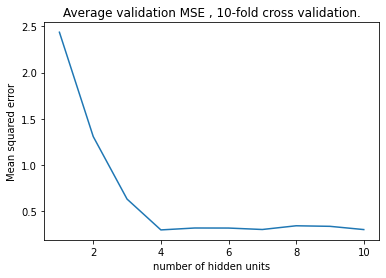

In [10]:
def Get_MSE():
  accuracy = []
  list_acc = []
  
  units = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  for unit in units:
    accuracy = []

    # Loop over all the k-validations
    for k in range(1, 10):
      
      y_pred = Train_Test_NN(unit, training_data[k], training_labels[k], validation_data[k])

      y_pred = y_pred.detach().numpy()

      # Store accuracy for the 10 cross validations for the current degree
      accuracy.append(mean_squared_error(y_pred, validation_labels[k]))

    print("MSE on average for number of hidden units: ", unit, ", is: ", (np.sum(np.array(accuracy))/k_cross))
    print(accuracy)
    list_acc.append((np.sum(np.array(accuracy))/k_cross))

  deg = [i for i in range(1, 11)]
  plt.title("Average validation MSE , 10-fold cross validation.")
  plt.xlabel("number of hidden units")
  plt.ylabel("Mean squared error")
  plt.plot(deg, list_acc)
  plt.show()

Get_MSE()

In [15]:
y_pred = Train_Test_NN(10, tot_train_data, tot_train_labels, test_data)
y_pred = y_pred.detach().numpy()
print("MSE on average for number of hidden units: ", 10, ", is: ", mean_squared_error(y_pred, test_labels))

MSE on average for number of hidden units:  10 , is:  0.39245921909630954
